In [2]:
import pandas as pd
import numpy as np

# import three files, takes very long
df_all = pd.read_csv('criteo-uplift-v2.1.csv')
df_treated = df_all[df_all.treatment == 1] #pd.read_csv('criteo_treated.csv', encoding='latin_1')
df_untreated = df_all[df_all.treatment == 0] #pd.read_csv('criteo_not_treated.csv', encoding='latin_1')

df_all.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [3]:
#These are the number of rows in each file. Treated and Untreated data were extracted from the total data.
count_all = df_all['conversion'].count()
count_treated = df_treated['conversion'].count()
count_untreated = df_untreated['conversion'].count()
print(count_all,count_treated,count_untreated)

13979592 11882655 2096937


#### By the number of untreated data, select these numbers of data randomly from all/treated/untreated
* 60% train = 1258163
* 20% validation = 419387
* 20% test = 419387
#### To do this, I shuffle each dataset and choose corresponding number of rows from them, so that we are in fact randomly selecting our training, validating and testing set

In [4]:
#Shuffle data to make sure random selection
from sklearn.utils import shuffle
df_untreated = shuffle(df_untreated)
df_treated = shuffle(df_treated)
df_all = shuffle(df_all)

In [5]:
#Set the number of train, validation and test data we want to use
train = 1258163   
val = 419387
test = 419387
learn = train

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

features = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']
def build_classifier(df, dependent_variable,learn):
    #print(dependent_variable)
    X, y = df[features][:learn], df[dependent_variable][:learn] #learning set is learn, validation set is train always
    X_val, y_val = df[features][train:train+val], df[dependent_variable][train:train+val]
    # If we use the default solver, the model does not converge
    clf = DecisionTreeClassifier(min_samples_leaf = 10000).fit(X, y)
    #print(f"Accuracy: {clf.score(X_val, y_val)}")
    #fpr, tpr, thresholds = metrics.roc_curve(y_val, clf.predict_proba(X_val)[:,1])
    #print(f"AUC: {metrics.auc(fpr, tpr)}")
    return clf
def build_classifier_regression(df, dependent_variable,learn):
    #print(dependent_variable)
    X, y = df[features][:learn], df[dependent_variable][:learn] #learning set is learn, validation set is train always
    X_val, y_val = df[features][train:train+val], df[dependent_variable][train:train+val]
    # If we use the default solver, the model does not converge
    clf = DecisionTreeRegressor(min_samples_leaf = 10000).fit(X, y)
    #print(f"Accuracy: {clf.score(X_val, y_val)}")
    #fpr, tpr, thresholds = metrics.roc_curve(y_val, clf.predict_proba(X_val)[:,1])
    #print(f"AUC: {metrics.auc(fpr, tpr)}")
    return clf

## Model 1: All data, predict conversion

In [45]:
#Model 1: run logistic regression for all data (including treated and untreated) to predict conversion
clf_all = build_classifier(df_all, 'conversion',learn)

## Model 2: All data, predict visit

In [46]:
#Model 2: run logistic regression for all data (including treated and untreated) to predict visit
clf_all_visit = build_classifier(df_all, 'visit',learn)

## Model 3: Treated data, predict conversion

In [47]:
clf_treated = build_classifier(df_treated, 'conversion',learn)

## Model 4: Treated data, predict visit

In [48]:
clf_treated_visit = build_classifier(df_treated, 'visit',learn)

## Model 5: Untreated data, predict conversion

In [49]:
clf_untreated = build_classifier(df_untreated, 'conversion',learn)

## Model 6: Untreated data, predict visit

In [50]:
clf_untreated_visit = build_classifier(df_untreated, 'visit',learn)

## Model 1 Prediction
### After building the models, we do evaluation and prediction using validation data
* some data in val_set might be the same with training data in untreated/treated data set
* val_set is completely separated from training data of model 1

In [11]:
val_set = df_all[train:train+val]

## Now we see the features of the validation set

In [12]:
#porportion of people treated
targeted = val_set.treatment.mean()
targeted

0.8502504846359091

In [29]:
#conversion rate on treated
treat_all = val_set[val_set.treatment == 1].conversion.mean()
treat_all

0.002896933120947659

In [30]:
#conversion rate on not treated
treat_none = val_set[val_set.treatment == 0].conversion.mean()
treat_none

0.001815199910832285

In [31]:
#conversion rate if treat randomly (according to the percentage treated)
treat_random = treat_all*targeted+treat_none*(1-targeted)
treat_random

0.0027349440969796396

## Now, we target top 10% and see the result

In [26]:
def do_targeting(scores, val_set):
    results = val_set[['treatment', 'conversion']].copy()
    # Do the targeting
    target_size = 41939 #10%
    bottom_score = np.sort(scores)[-target_size]
    results['target_decision'] = (scores >= bottom_score).astype(int)
    # Estimate rewards
    matches = results.target_decision == results.treatment.values
    treatment_rate = val_set.treatment.mean()
    weights = results.treatment * treatment_rate + (1 - results.treatment) * (1 - treatment_rate)
    results['reward'] = val_set.conversion.values * matches / weights
    return results

#all_scores = clf_all.predict_proba(val_set[features])[:, 1]
#m1 = do_targeting(all_scores, val_set)
#m1.reward.value_counts()

In [27]:
#calculte effects
def effect(m):
    treat_with_model = m.reward.mean()
    for_target_treated = m[m.target_decision * m.treatment == 1].conversion.mean()
    for_target_untreated = m[m.target_decision * (1-m.treatment) == 1].conversion.mean()
    avg_effect = treat_all-treat_none
    effect_for_targeted = for_target_treated - for_target_untreated
    return treat_with_model,for_target_treated,for_target_untreated,avg_effect,effect_for_targeted

#effect1 = effect(m1)
#effect1

## Model 3 Prediction 

In [19]:
tr_scores = clf_treated.predict_proba(val_set[features])[:, 1]
m3 = do_targeting(tr_scores, val_set)
m3.reward.value_counts()

0.000000    418427
1.176731       939
6.658310        21
Name: reward, dtype: int64

In [20]:
effect3 = effect(m3)
effect3

(0.002968082265278479,
 0.025942093048955686,
 0.01706425213303152,
 0.0010961309120188466,
 0.008877840915924168)

## Model 5 Prediction

In [21]:
un_scores = clf_untreated.predict_proba(val_set[features])[:, 1]
m5 = do_targeting(un_scores, val_set)
m5.reward.value_counts()

0.000000    418426
1.176731       940
6.658310        21
Name: reward, dtype: int64

In [22]:
effect5 = effect(m5)
effect5

(0.0029708881014176482,
 0.026025083750934413,
 0.01683848797250859,
 0.0010961309120188466,
 0.009186595778425823)

## Uplift Prediction
* Create an uplift model by using prediction of treated - untreated

In [23]:
up_scores = tr_scores - un_scores
up = do_targeting(up_scores, val_set)
up.reward.value_counts()

0.000000    418441
1.176731       925
6.658310        21
Name: reward, dtype: int64

In [24]:
effect_up = effect(up)
effect_up

(0.002928800559330108,
 0.025498249579623454,
 0.017308371600141294,
 0.0010961309120188466,
 0.00818987797948216)

### Use Spearmanr correlation to see how closely these models are ranking things

In [25]:
from scipy import stats
stats.spearmanr(all_scores, tr_scores)

SpearmanrResult(correlation=0.9966824583563189, pvalue=0.0)

In [26]:
stats.spearmanr(all_scores, un_scores)

SpearmanrResult(correlation=0.9728851038043155, pvalue=0.0)

In [27]:
stats.spearmanr(tr_scores, un_scores)

SpearmanrResult(correlation=0.9813267666099121, pvalue=0.0)

In [28]:
stats.spearmanr(all_scores, up_scores)

SpearmanrResult(correlation=0.9759418497786646, pvalue=0.0)

In [29]:
stats.spearmanr(tr_scores, up_scores)

SpearmanrResult(correlation=0.9723228431266762, pvalue=0.0)

In [30]:
stats.spearmanr(un_scores, up_scores)

SpearmanrResult(correlation=0.9154893002982973, pvalue=0.0)

## Summarize effect for models

In [31]:
result = pd.DataFrame(np.array([np.array(effect1),np.array(effect3),np.array(effect5),np.array(effect_up)]),index = ['model_all','model_treated','model_untreated','uplift'],columns = ['treat_with_model','for_target_treated','for_target_untreated','avg_effect','effect_for_targeted'])
result

,treat_with_model,for_target_treated,for_target_untreated,avg_effect,effect_for_targeted
model_all,0.002981,0.025920,0.016867,0.001096,0.009054
model_treated,0.002968,0.025942,0.017064,0.001096,0.008878
model_untreated,0.002971,0.026025,0.016838,0.001096,0.009187
uplift,0.002929,0.025498,0.017308,0.001096,0.008190


## Learning curve 12.20

In [78]:
def auc(model,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model.predict_proba(val_set[features])[:,1])
    return metrics.auc(fpr, tpr)
def auc_up(model_tr,model_un,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model_tr.predict_proba(val_set[features])[:,1]-model_un.predict_proba(val_set[features])[:,1])
    return metrics.auc(fpr, tpr)
def auc_x(model0,model1,dependent_variable):
    fpr, tpr, thresholds = metrics.roc_curve(val_set[dependent_variable], model0.predict(val_set[features])*(1-targeted)+model1.predict(val_set[features])*(targeted))
    return metrics.auc(fpr, tpr)

In [99]:
def reward(model):
    all_scores = model.predict_proba(val_set[features])[:, 1]
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1]
def reward_up(model_tr,model_un):
    all_scores = model_tr.predict_proba(val_set[features])[:, 1]-model_un.predict_proba(val_set[features])[:, 1]
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1],all_scores
def reward_x(model_tr,model_un):
    all_scores = model0.predict(val_set[features])*(1-targeted)+model1.predict(val_set[features])*(targeted)
    m_temp = do_targeting(all_scores, val_set)
    return effect(m_temp)[0],effect(m_temp)[-1]
#reward, effect_for_targeted
# number of positives as a f of score percentile for uplift, large dataset before jump +tiny dataset (not powerful) model, same distribution?



### Model 1: All data, conversion

In [51]:
auc_score = []
reward_score = []
effect_score = []
for l in range(10000,500000,10000):
    model = build_classifier(df_all, 'conversion',l)
    auc_score.append(auc(model,'conversion'))
    reward_score.append(reward(model)[0])
    effect_score.append(reward(model)[1])

In [39]:
import matplotlib.pyplot as plt
def draw_learning(reward_score,effect_score,a,b,step):
    x = [i for i in range(a,b,step)]
    plt.plot(x, reward_score,label = 'reward')
    #plt.plot(x, auc_score,label = 'auc_score')
    plt.plot(x, effect_score, label = 'effect on targeted')
    plt.xscale('log')
    plt.xlabel('# of train data')
    plt.ylabel('evaluation score')
    plt.legend()
def draw_learning_auc(auc_score,a,b,step):
    x = [i for i in range(a,b,step)]
    #plt.plot(x, reward_score,label = 'reward_score')
    plt.plot(x, auc_score,label = 'auc_score')
    #plt.plot(x, effect_score, label = 'effect_score')
    plt.xscale('log')
    plt.xlabel('# of train data')
    plt.ylabel('AUC score')
    plt.legend()

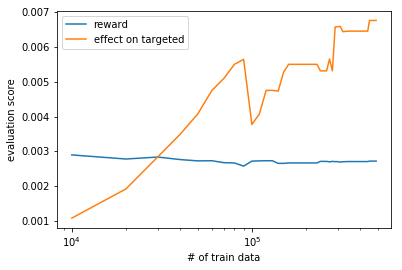

In [52]:
draw_learning(reward_score,effect_score,10000,500000,10000)

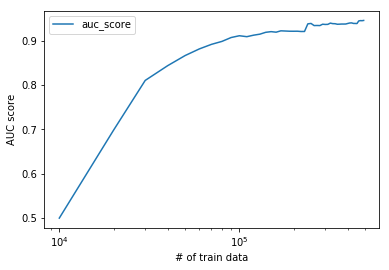

In [53]:
draw_learning_auc(auc_score,10000,500000,10000)

### AUC stops increasing at 100,000
### reward is constant at 0.003
### effect on targeted is around 0.004

In [59]:
reward_score1 = []
effect_score1 = []
for l in range(1000,train,10000):
    model = build_classifier(df_all, 'conversion',l)
    auc_score.append(auc(model,'conversion'))
    reward_score1.append(reward(model)[0])
    effect_score1.append(reward(model)[1])

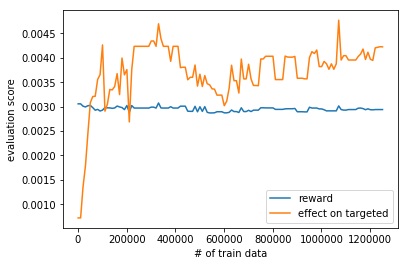

In [60]:
draw_learning(reward_score1,effect_score1,1000,train,10000)

### Model 1: 
* AUC around 0.91 to 0.95 when # of train data >= 100,000
* reward constant around 0.3
* effect on targeted between (0.0030 to 0.0045)

## Model 3: Treated data, conversion

In [54]:
auc_score3 = []
reward_score3 = []
effect_score3 = []
for l in range(10000,500000,10000):
    model = build_classifier(df_treated, 'conversion',l)
    auc_score3.append(auc(model,'conversion'))
    reward_score3.append(reward(model)[0])
    effect_score3.append(reward(model)[1])

In [85]:
#draw_learning(reward_score3,effect_score3,10000,500000,10000)

In [86]:
#draw_learning_auc(auc_score3,10000,500000,10000)

## Model 5: Treated data, conversion

In [55]:
auc_score5 = []
reward_score5 = []
effect_score5 = []
for l in range(10000,500000,10000):
    model = build_classifier(df_untreated, 'conversion',l)
    auc_score5.append(auc(model,'conversion'))
    reward_score5.append(reward(model)[0])
    effect_score5.append(reward(model)[1])

## Uplift (T-learner)

In [67]:
# start with all untreated, increase treated data
auc_score_up2 = []
reward_score_up2 = []
effect_score_up2 = []
model_un = build_classifier(df_untreated, 'conversion',500000)########## constant untreated for now
for l in range(10000,500000,10000):
    model_tr = build_classifier(df_treated, 'conversion',l)
   
    auc_score_up2.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up2.append(reward_up(model_tr,model_un)[0])
    effect_score_up2.append(reward_up(model_tr,model_un)[1])

In [61]:
# increase both treated and untreated data 10000,500000,10000
auc_score_up = []
reward_score_up = []
effect_score_up = []
for l in range(10000,500000,10000):
    model_tr = build_classifier(df_treated, 'conversion',l)
    model_un = build_classifier(df_untreated, 'conversion',l)########## constant untreated for now
    auc_score_up.append(auc_up(model_tr,model_un,'conversion'))
    reward_score_up.append(reward_up(model_tr,model_un)[0])
    effect_score_up.append(reward_up(model_tr,model_un)[1])

In [68]:
def compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_up2,title):

    x = [i for i in range(10000,500000,10000)]
    plt.plot(x, auc_score,label = 'All')
    plt.plot(x, auc_score3,label = 'Treated')
    plt.plot(x, auc_score5,label = 'Untreated')
    plt.plot(x, auc_score_up,label = 'Uplift(varying both)')
    plt.plot(x, auc_score_up2,label = 'Uplift(varying treated data)')
    
    plt.xscale('log')

    plt.xlabel('# of train data')
    plt.ylabel(title)
    plt.legend()

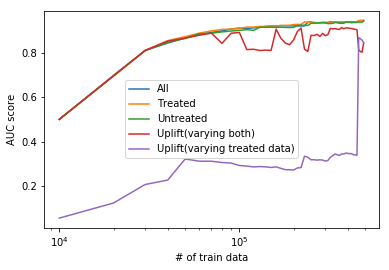

In [70]:
compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_up2[1:],'AUC score')

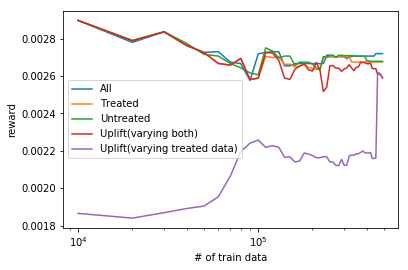

In [71]:
compare(reward_score,reward_score3,reward_score5,reward_score_up,reward_score_up2[1:],'reward') ##### why is reward going down

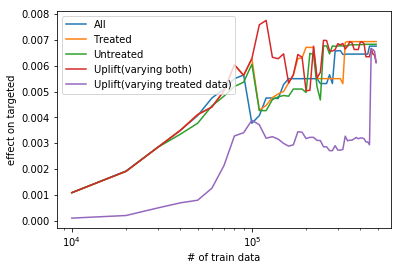

In [72]:
compare(effect_score,effect_score3,effect_score5,effect_score_up,effect_score_up2[1:],'effect on targeted')

### 200,000

## X-learner

In [13]:
def x_learner(train):
    model_tr = build_classifier(df_treated, 'conversion',train)
    model_un = build_classifier(df_untreated, 'conversion',train)
    d1 = df_treated['conversion']-model_un.predict_proba(df_treated[features])[:, 1]
    d2 = model_tr.predict_proba(df_untreated[features])[:, 1]-df_untreated['conversion']
    df_d1 = df_treated[features]
    df_d2 = df_untreated[features]
    df_d1['d1'] = d1
    df_d2['d2'] = d2
    #print(df_d1.columns)
    model3 = build_classifier_regression(df_d1, 'd1',train) # what models to use for the second stage?
    model4 = build_classifier_regression(df_d2, 'd2',train)
    #0.85,0.15 (which one?)
    return model3, model4

In [16]:
x_learner0 = x_learner(10000)[0]
x_learner1 = x_learner(10000)[1]

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [80]:
auc_score_x = []
reward_score_x = []
effect_score_x = []
for l in range(10000,500000,10000):
    model0 = x_learner(l)[0]
    model1 = x_learner(l)[1]
   
    auc_score_x.append(auc_x(model0,model1,'conversion'))
    reward_score_x.append(reward_x(model0,model1)[0])
    effect_score_x.append(reward_x(model0,model1)[1])

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Huanci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

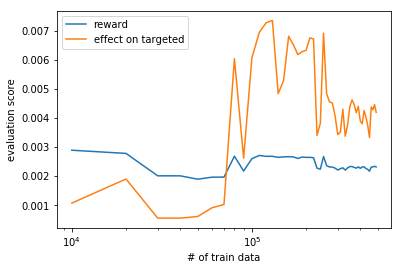

In [81]:
draw_learning(reward_score_x,effect_score_x,10000,500000,10000)

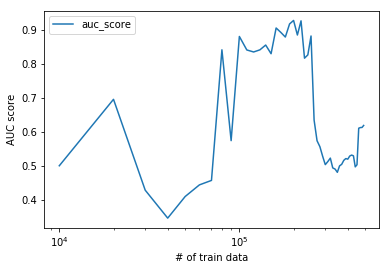

In [82]:
draw_learning_auc(auc_score_x,10000,500000,10000)

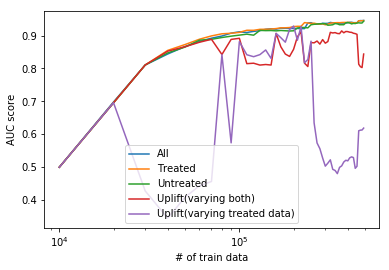

In [84]:
compare(auc_score,auc_score3,auc_score5,auc_score_up,auc_score_x, 'AUC score')

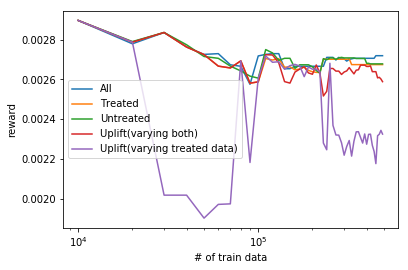

In [85]:
compare(reward_score,reward_score3,reward_score5,reward_score_up,reward_score_x,'reward')

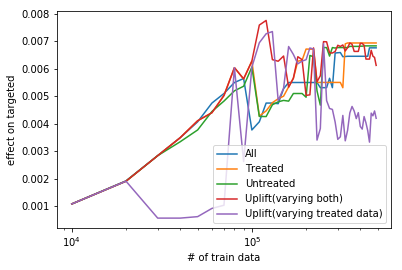

In [86]:
compare(effect_score,effect_score3,effect_score5,effect_score_up,effect_score_x,'effect on targeted')

In [87]:
auc_score

[0.5,
 0.6981065192688554,
 0.8105198731229935,
 0.8438265163054681,
 0.8666408211034542,
 0.8816368861102013,
 0.8918538072774258,
 0.8984806083649239,
 0.9072404813895267,
 0.9112619227564807,
 0.9091431580854616,
 0.9125533403479621,
 0.9148270991855938,
 0.9189964180867691,
 0.9204980921421706,
 0.9192854817697476,
 0.9223435481119371,
 0.9219009213016358,
 0.9214509412632269,
 0.9214021275020362,
 0.9214823230272378,
 0.920835139937924,
 0.9209118699091273,
 0.9381086544670272,
 0.938983110150961,
 0.9341978252455259,
 0.9344069675208069,
 0.9341992427352815,
 0.9372500204702197,
 0.9367090125749685,
 0.9369318430068393,
 0.9397457707108594,
 0.938554545672854,
 0.9383843729008645,
 0.93717741893793,
 0.9373774257001899,
 0.9376650322870812,
 0.9376252685726179,
 0.9377336043962861,
 0.9389538160575241,
 0.9399895852024742,
 0.9402323907749099,
 0.9390278194454913,
 0.9389670278958648,
 0.9387886347255641,
 0.944624910114473,
 0.9453617796567207,
 0.9451690229376524,
 0.9457617827

In [88]:
auc_score_up2

[0.0548685186531646,
 0.0548685186531646,
 0.12297097598005241,
 0.20655602144645321,
 0.2262590175278445,
 0.3212120223226287,
 0.3113173924658918,
 0.3112468244060384,
 0.30553730282717495,
 0.3030308171861794,
 0.2921142439209701,
 0.2892755216112156,
 0.28568830947003226,
 0.2872345177182884,
 0.2859895135358598,
 0.28317539405381387,
 0.2858267064992405,
 0.27905189238217665,
 0.27320104603239614,
 0.27288796110941754,
 0.2715753926946914,
 0.2807604959696597,
 0.2826614622974407,
 0.3338092860921242,
 0.32948794662600744,
 0.31785941203191986,
 0.31793015832026467,
 0.3162344768195399,
 0.31770497964985006,
 0.3164982800012541,
 0.3120654424585877,
 0.31442829052736626,
 0.32847354613912483,
 0.33645332973346526,
 0.34389923144539264,
 0.34010349196933687,
 0.3372838161359029,
 0.3444312705911232,
 0.3437192529795634,
 0.34802511783508955,
 0.3465782839568843,
 0.345528977784767,
 0.3453734562285834,
 0.3399902616369238,
 0.3400957103674867,
 0.338210557388657,
 0.868134222646950

In [126]:
model_tr = build_classifier(df_treated, 'conversion',10000)
model_un = build_classifier(df_untreated, 'conversion',500000)########## constant untreated for now
#auc_score_up.append(auc_up(model_tr,model_un,'conversion'))
#reward_score_up.append(reward_up(model_tr,model_un)[0])

In [127]:
tr_score = model_tr.predict_proba(val_set[features])[:,1]
un_score = model_un.predict_proba(val_set[features])[:,1]
d = tr_score-un_score

In [128]:
df = pd.DataFrame(data = np.array([val_set['conversion'],tr_score,un_score,d]))

In [129]:
df = df.T


In [130]:
df = df.rename(columns = {0:'target',1:'tr',2:'un',3:'dif'})

In [131]:
df = df.sort_values(by='dif')

In [132]:
df

,target,tr,un,dif
123014,0.0,0.0026,0.061196,-0.058596
389299,0.0,0.0026,0.061196,-0.058596
212873,0.0,0.0026,0.061196,-0.058596
187405,0.0,0.0026,0.061196,-0.058596
324041,0.0,0.0026,0.061196,-0.058596
222793,0.0,0.0026,0.061196,-0.058596
165514,0.0,0.0026,0.061196,-0.058596
294859,0.0,0.0026,0.061196,-0.058596
222783,0.0,0.0026,0.061196,-0.058596
351011,0.0,0.0026,0.061196,-0.058596


In [137]:
df['un'].value_counts()

0.000000    218871
0.000200     16603
0.000161     15630
0.000812     15218
0.004850     13752
0.000245     13715
0.000064     12814
0.002676     11586
0.001372     10742
0.000238     10498
0.000421     10010
0.001887      9569
0.011571      9404
0.061196      8760
0.000392      8734
0.000399      8685
0.001200      8511
0.000400      8167
0.000600      8118
Name: un, dtype: int64

In [138]:
df['tr'].value_counts()

0.0026    419387
Name: tr, dtype: int64